In [23]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import networkx as nx
import asyncio
import aiohttp
import matplotlib.pyplot as plt
import powerlaw
from collections import Counter
from community import community_louvain
from matplotlib.cm import ScalarMappable
from sklearn.metrics import adjusted_rand_score
import random

In [6]:
import os
import json

# Specify the path to the folder containing JSON files
data_folder_path = '../data/'

# Create an empty dictionary to store data
all_data = {}

# Iterate over all files in the folder
for filename in os.listdir(data_folder_path):
    if filename.endswith(".json"):
        # Form the complete path to the JSON file
        json_file_path = os.path.join(data_folder_path, filename)
        
        # Read the JSON file and store its content in the dictionary
        with open(json_file_path, 'r') as file:
            # Use the filename (without extension) as the key in the dictionary
            all_data[os.path.splitext(filename)[0]] = json.load(file)

In [7]:
### Add sentiment score as a character attribute

characters_infobox = all_data['characters_infobox']
sentiment_scores_characters = all_data['sentiment_scores_charachters']

# Iterate through keys in 'characters_infobox'
for character, info in characters_infobox.items():
    # Check if the character key exists in 'sentiment_scores_characters'
    if character in sentiment_scores_characters:
        # Add the sentiment score to the 'characters_infobox' dictionary
        info['Sentiment Score'] = sentiment_scores_characters[character]


In [8]:
def create_character_interaction_graph(data, season=None, characters_info=None):
    graph_dict = {}  # Initialize an empty dictionary to store graphs
    count = 1  # Initializing a count

    # Loop over every season
    if season is None:
        for season_name, episodes_data in data.items():
            for i in range(len(episodes_data)):
                G = nx.Graph()  # Create a new directed graph for each episode
                characters = episodes_data[i]["Characters"]  # Characters from each episode as a list

                # Add nodes from the previous graph (if it exists). Control statement for the first graph
                if count > 1:
                    G.add_nodes_from(graph_dict[f'G{count-1}'].nodes)  # Getting the nodes (characters) from the previous graph (episode)

                    # Add edges and update weights from the previous graph
                    for edge in graph_dict[f'G{count-1}'].edges(data=True):
                        char1, char2, data = edge
                        weight = data.get('weight', 0)
                        G.add_edge(char1, char2, weight=weight)

                # Add new characters as nodes
                if characters is not None:  # Control statement if the list of characters is empty/None type
                    G.add_nodes_from(characters)  # Adding the characters

                    # Add weighted edges for characters appearing in the same episode
                    for char1 in characters:
                        for char2 in characters:
                            if char1 != char2:
                                if G.has_edge(char1, char2):
                                    G[char1][char2]['weight'] += 1
                                else:
                                    G.add_edge(char1, char2, weight=1)

                graph_dict[f'G{count}'] = G  # Appending the evolving graph to the dictionary
                count += 1  # Updating the count

    else:
        # Initialize graph and graph dict to append the graphs
        season_data = data[season]  
        graph_dict = {}  # Initialize an empty dictionary to store graphs
        count = 1  # Initializing a count

        # Loop over every episode
        for i in range(len(season_data)):
            G = nx.Graph()  # Create a new directed graph for each episode
            characters = season_data[i]["Characters"]  # Characters from each episode as a list

            # Add nodes from the previous graph (if it exists). Control statement for the first graph
            if count > 1:
                G.add_nodes_from(graph_dict[f'G{count-1}'].nodes)  # Getting the nodes (characters) from the previous graph (episode)
                
                # Add edges and update weights from the previous graph
                for edge in graph_dict[f'G{count-1}'].edges(data=True):
                    char1, char2, data = edge
                    weight = data.get('weight', 0)
                    G.add_edge(char1, char2, weight=weight)

            # Add new characters as nodes
            if characters is not None:  # Control statement if the list of characters is empty/None type
                G.add_nodes_from(characters)  # Adding the characters

                # Add weighted edges for characters appearing in the same episode
                for char1 in characters:
                    for char2 in characters:
                        if char1 != char2:
                            if G.has_edge(char1, char2):
                                G[char1][char2]['weight'] += 1
                            else:
                                G.add_edge(char1, char2, weight=1)

            graph_dict[f'G{count}'] = G  # Appending the evolving graph to the dictionary
            count += 1  # Updating the count

    # Add node attributes to all graphs
    if characters_info:
        for key, graph in graph_dict.items():
            add_node_attributes(graph, characters_info)

    return graph_dict

# Adding the note attributes from the characters' infobox.
def add_node_attributes(graph, attributes_dict):
    for node, attributes in attributes_dict.items():
        # Normalize the node name
        normalized_node = next((n for n in graph.nodes if node.lower() == n.lower()), None)
        
        # Check if the normalized node exists in the graph
        if normalized_node:
            graph.nodes[normalized_node].update(attributes)

In [61]:
# The dictionary of the 1013 graphs of all the episodes with the characters as nodes. Attributes are added from their infobox on the fandom page.
graph_dict_all_seasons = create_character_interaction_graph(all_data["episodes_seasons_characters"], characters_info=all_data['characters_infobox'])

In [62]:
graph_G1013 = graph_dict_all_seasons['G1013']

#### Partitioning Based On Villages

Modularity: 0.2930738579816501


C:\Users\Ata\AppData\Local\Temp\ipykernel_9020\2139833660.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nx.draw_networkx_nodes(graph_G1013, pos, node_size=200, node_color=list(partition.values()), cmap=plt.cm.get_cmap('viridis'), alpha=0.8)
C:\Users\Ata\AppData\Local\Temp\ipykernel_9020\2139833660.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  sm = ScalarMappable(cmap=plt.cm.get_cmap('viridis'))


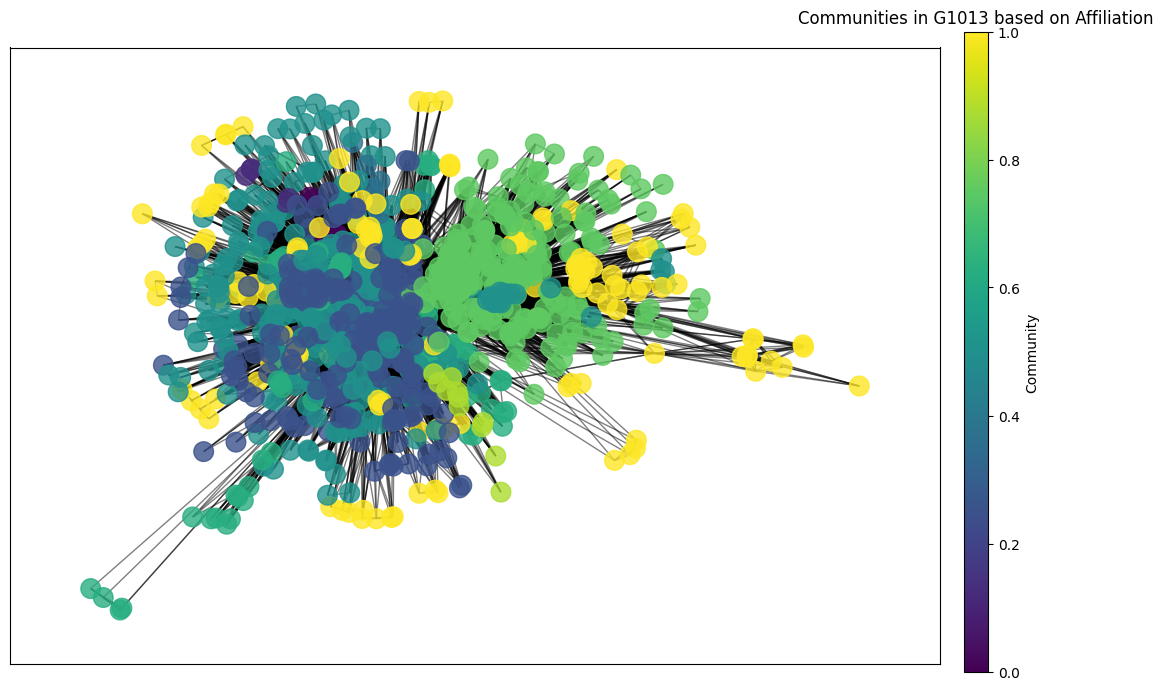

In [34]:
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain
from matplotlib.cm import ScalarMappable


# Assuming graph_G1013 is your networkx graph
# Assuming 'Affiliation' attribute is available for nodes

# Define the villages to check for in the 'Affiliation' attribute
target_villages = ["Konohagakure", "Sunagakure", "Kirigakure", "Kumogakure", "Iwagakure"]

# Create a dictionary to store the mapping of nodes to communities
node_community_mapping = {}

# Iterate through nodes and partition based on the 'Affiliation' attribute
for node in graph_G1013.nodes:
    affiliation_list = graph_G1013.nodes[node].get('Affiliation', [])

    # Check if the affiliation list contains any of the target villages
    matching_villages = [village for village in target_villages if village in affiliation_list]

    if matching_villages:
        # Use one of the matching villages (select the first one in this example)
        community_label = matching_villages[0]
    elif affiliation_list:
        # If no matching villages but the list is not empty, use a random village
        community_label = random.choice(affiliation_list)
    else:
        # If the list is empty, label as 'None'
        community_label = 'None'

    # Assign the community label to the node
    node_community_mapping[node] = community_label

# Perform Louvain community detection based on the assigned communities
partition = community_louvain.best_partition(graph_G1013, partition=node_community_mapping)

# Add the Louvain community information to the node attributes
nx.set_node_attributes(graph_G1013, partition, 'community')

# Compute modularity
modularity = community_louvain.modularity(partition, graph_G1013)
print(f"Modularity: {modularity}")

# Visualize the communities on the network
pos = nx.spring_layout(graph_G1013, seed=42)  # You can use a different layout if needed

plt.figure(figsize=(12, 8))

# Draw network nodes and edges
nx.draw_networkx_nodes(graph_G1013, pos, node_size=200, node_color=list(partition.values()), cmap=plt.cm.get_cmap('viridis'), alpha=0.8)
nx.draw_networkx_edges(graph_G1013, pos, alpha=0.5)

# Add colorbar in a separate subplot
cax = plt.axes([0.92, 0.1, 0.02, 0.8])  # [x, y, width, height]
sm = ScalarMappable(cmap=plt.cm.get_cmap('viridis'))
sm.set_array([])
plt.colorbar(sm, label='Community', cax=cax)

plt.title("Communities in G1013 based on Affiliation")
plt.show()


#### Partitioning based on Louvain Community Detection Algorithm

In [63]:
# Handle missing attributes by setting 'None'
for node in graph_G1013.nodes:
    for attribute in graph_G1013.nodes[node]:
        if attribute not in graph_G1013.nodes[node]:
            graph_G1013.nodes[node][attribute] = 'None'

In [65]:
# Perform Louvain community detection
partition = community_louvain.best_partition(graph_G1013)

# Add the community information to the node attributes
nx.set_node_attributes(graph_G1013, partition, 'community')

# Print the communities
communities = {}
for node, community in partition.items():
    if community not in communities:
        communities[community] = [node]
    else:
        communities[community].append(node)

# Print the communities
for community, nodes in sorted(communities.items()):
    print(f"Community {community}: {nodes}")


Community 0: ['Dokku', 'Leo', 'Miina', 'Faz', 'Sora (orphan)', 'Lando', 'Shiseru', 'Disonasu', 'Tonika Village Head']
Community 1: ['Naruto Uzumaki', 'Sasuke Uchiha', 'Sakura Haruno', 'Hiruzen Sarutobi', 'Iruka', 'Shikamaru Nara', 'Ino Yamanaka', 'Hinata Hyūga', 'Mizuki', 'Bekkō', 'Iwana', 'Yajirobee', 'Ibara', 'Tsubaki (parent)', 'Iruka Umino', 'Konohamaru', 'Ebisu', 'Genzō', 'Sexy Technique', 'Kakashi Hatake', 'Chōji Akimichi', 'Kiba Inuzuka', 'Asuma Sarutobi', 'Kurenai Yūhi', 'Tobio', 'Mebuki Haruno', 'Tazuna', 'Zabuza Momochi', 'Gatō', 'Meizu', 'Madam Shijimi', 'Kaji', 'Haku', 'Tsunami', 'Inari', 'Waraji', 'Zōri', 'Kaiza', 'Giichi', 'Akane', 'Ageha', "Haku's mother", 'Agari', 'Moegi', 'Udon', 'Rock Lee', 'Neji Hyūga', 'Tenten', 'Kotetsu Hagane', 'Izumo Kamizuki', 'Zaku Abumi', 'Dosu Kinuta', 'Might Guy', 'Kabuto Yakushi', 'Ibiki Morino', 'Shino Aburame', 'Kin Tsuchi', 'Tonbo Tobitake', 'Sukima', 'Nejiri', 'Komaza', 'Genin', 'Oboro', 'Team Shiore', 'Shiore', 'Itachi Uchiha', 'Mozuku

In [36]:
partition = community_louvain.best_partition(graph_G1013)
modularity = community_louvain.modularity(partition, graph_G1013)

print(f"Modularity: {modularity}")

Modularity: 0.3142241713480827


C:\Users\Ata\AppData\Local\Temp\ipykernel_9020\3116857675.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nx.draw_networkx_nodes(graph_G1013, pos, node_size=200, node_color=node_colors, cmap=plt.cm.get_cmap('viridis'), alpha=0.8)
C:\Users\Ata\AppData\Local\Temp\ipykernel_9020\3116857675.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  sm = ScalarMappable(cmap=plt.cm.get_cmap('viridis'))


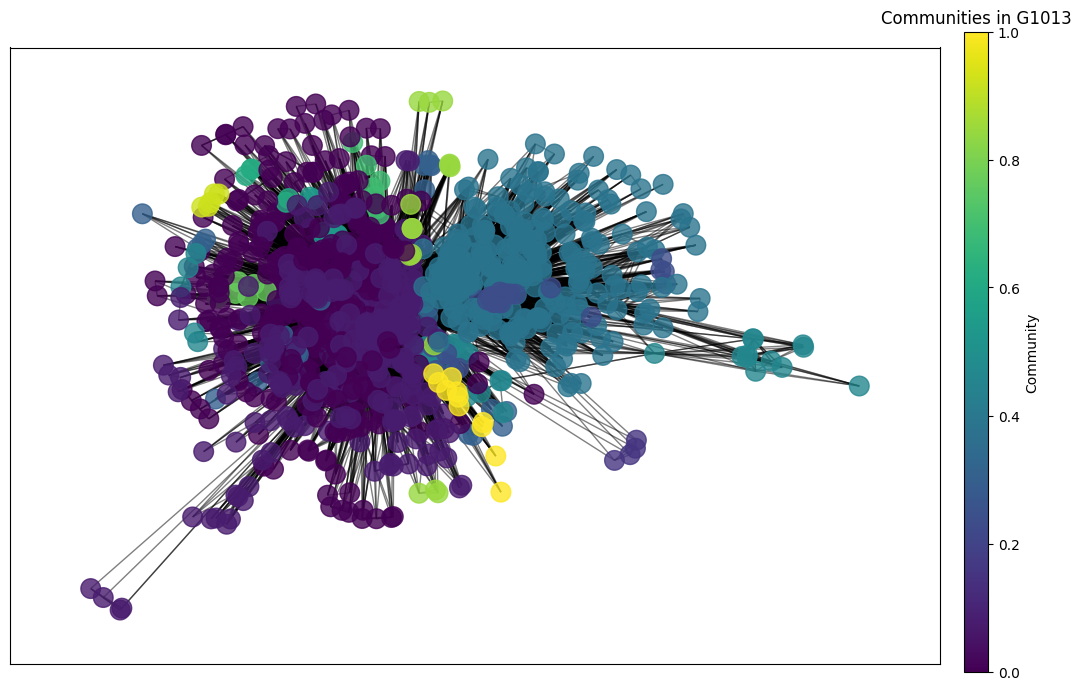

In [37]:
# Visualize the communities on the network
pos = nx.spring_layout(graph_G1013, seed=42)  # You can use a different layout if needed
node_colors = [partition[node] for node in graph_G1013.nodes]

plt.figure(figsize=(12, 8))

# Draw network nodes and edges
nx.draw_networkx_nodes(graph_G1013, pos, node_size=200, node_color=node_colors, cmap=plt.cm.get_cmap('viridis'), alpha=0.8)
nx.draw_networkx_edges(graph_G1013, pos, alpha=0.5)

# Add colorbar in a separate subplot
cax = plt.axes([0.92, 0.1, 0.02, 0.8])  # [x, y, width, height]
sm = ScalarMappable(cmap=plt.cm.get_cmap('viridis'))
sm.set_array([])
plt.colorbar(sm, label='Community', cax=cax)

plt.title("Communities in G1013")
plt.show()

#### Evaluate Feature Importance of Node Attributes

In [69]:
# import numpy as np
# import networkx as nx
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# from tensorflow.keras.preprocessing.sequence import pad_sequences

# # Check if the graph has nodes
# if not graph_G1013.nodes:
#     print("The graph has no nodes.")
# else:
#     # Check if the nodes have attributes
#     all_node_attributes = None
#     for node, attributes in graph_G1013.nodes(data=True):
#         all_node_attributes = list(attributes.keys())
#         break  # Break after the first node to get attribute names

#     if not all_node_attributes:
#         print("Nodes in the graph have no attributes.")
#     else:
#         # Create the feature matrix X using all node attributes
#         X = [list(nx.get_node_attributes(graph_G1013, attr).values()) for attr in all_node_attributes]

#         # Pad sequences to have the same length
#         X_padded = pad_sequences(X, padding='post', dtype='float32')

#         # Ensure the number of features matches the number of nodes
#         assert X_padded.shape[0] == len(graph_G1013.nodes), "Number of features does not match the number of nodes"

#         # Extract the community labels
#         y = np.array(list(nx.get_node_attributes(graph_G1013, 'community').values()))

#         # Split the data into training and testing sets
#         X_train, X_test, y_train, y_test = train_test_split(X_padded.T, y, test_size=0.2, random_state=42)

#         # Train a RandomForest Model
#         rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
#         rf_model.fit(X_train, y_train)

#         # Evaluate the model
#         accuracy = rf_model.score(X_test.T, y_test)
#         print(f"Accuracy: {accuracy:.2f}")



# # Step 3: Get the top 5 features
# feature_importances = rf_model.feature_importances_
# sorted_indices = np.argsort(feature_importances)[::-1]
# top_5_features = sorted_indices[:5]

# # Step 4: Keep only the top 5 features in the node attributes
# for i, node in enumerate(graph_G1013.nodes):
#     top_5_values = [graph_G1013.nodes[node][f'attribute_{j + 1}'] for j in top_5_features]
#     for j, value in zip(top_5_features, top_5_values):
#         graph_G1013.nodes[node][f'top_feature_{j + 1}'] = value

# # Step 5: Perform Louvain community detection based on the top 5 features
# partition = community_louvain.best_partition(graph_G1013)

# # Add the Louvain community information to the node attributes
# nx.set_node_attributes(graph_G1013, partition, 'community')

# # Visualize the communities on the network
# pos = nx.spring_layout(graph_G1013, seed=42)  # You can use a different layout if needed

# plt.figure(figsize=(12, 8))

# # Draw network nodes and edges
# nx.draw_networkx_nodes(graph_G1013, pos, node_size=200, node_color=list(partition.values()), cmap=plt.cm.get_cmap('viridis'), alpha=0.8)
# nx.draw_networkx_edges(graph_G1013, pos, alpha=0.5)

# # Add colorbar in a separate subplot
# cax = plt.axes([0.92, 0.1, 0.02, 0.8])  # [x, y, width, height]
# sm = ScalarMappable(cmap=plt.cm.get_cmap('viridis'))
# sm.set_array([])
# plt.colorbar(sm, label='Community', cax=cax)

# plt.title("Communities in G1013 based on Top 5 Node Attributes")
# plt.show()


ValueError: could not convert string to float: 'October 10'

#### Build the Threshold Graphs

In [70]:
def filter_edges_below_threshold(graph, threshold):
    # Create a copy of the graph to avoid modifying the original graph
    filtered_graph = graph.copy()

    # Iterate through edges and remove those below the threshold
    edges_to_remove = [(u, v) for u, v, w in graph.edges(data='weight') if w < threshold]
    filtered_graph.remove_edges_from(edges_to_remove)

    # Identify isolated nodes and remove them
    isolated_nodes = [node for node in filtered_graph.nodes() if filtered_graph.degree(node) == 0]
    filtered_graph.remove_nodes_from(isolated_nodes)

    return filtered_graph

In [96]:
G1013_filtered = filter_edges_below_threshold(graph_dict_all_seasons['G1013'], 20)

In [97]:
# Handle missing attributes by setting 'None'
for node in G1013_filtered.nodes:
    for attribute in G1013_filtered.nodes[node]:
        if attribute not in G1013_filtered.nodes[node]:
            G1013_filtered.nodes[node][attribute] = 'None'

# Perform Louvain community detection
partition = community_louvain.best_partition(G1013_filtered)

# Add the community information to the node attributes
nx.set_node_attributes(G1013_filtered, partition, 'community')

# Print the communities
communities = {}
for node, community in partition.items():
    if community not in communities:
        communities[community] = [node]
    else:
        communities[community].append(node)

# Print the communities
for community, nodes in sorted(communities.items()):
    print(f"Community {community}: {nodes}")

partition = community_louvain.best_partition(G1013_filtered)
modularity = community_louvain.modularity(partition, G1013_filtered)

print(f"Modularity: {modularity}")


Community 0: ['Konohamaru Sarutobi', 'Chōjūrō', 'Kurotsuchi', 'Boruto Uzumaki', 'Sarada Uchiha', 'Shikadai Nara', 'Chōchō Akimichi', 'Hinata Uzumaki', 'Himawari Uzumaki', 'Denki Kaminarimon', 'Wasabi Izuno', 'Namida Suzumeno', 'Inojin Yamanaka', 'Sumire Kakei', 'Iwabee Yuino', 'Metal Lee', 'Temari Nara', 'Mitsuki', 'Sai Yamanaka', 'Momoshiki Ōtsutsuki', 'Sakura Uchiha', 'Kagura Karatachi', 'Buntan Kurosuki', 'Hebiichigo', 'Kyohō Fuefuki', 'Kōtarō Fūma', 'Katasuke Tōno', 'Moegi Kazamatsuri', 'Shinki', 'Araya', 'Yodo', 'Sekiei', 'Kirara', 'Tsubaki Kurogane', 'Jigen', 'Mugino', 'Victor', 'Deepa', 'Amado', 'Delta', 'Koji Kashin', 'Boro', 'Code', 'Kawaki', 'Isari Funato', 'Araumi Funato']
Community 1: ['Ehō Norimaki', 'Yuina Itomaki', 'Kae Yukiwari', 'Sōsha Amino', 'Osuka Kamakura', 'Neon Asakusa', 'Harika Aburame', 'Eiki Fūma', 'Konashi Nerikiri', 'Soul Tao', 'Kura Kageno', 'Ran Sōgi', 'Suzu Sōgi', 'Hana Kaka']
Community 2: ['Sasuke Uchiha', 'Gaara', 'Temari', 'Kankurō', 'Zaku Abumi', 'Ita

C:\Users\Ata\AppData\Local\Temp\ipykernel_9020\3689565242.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  nx.draw_networkx_nodes(G1013_filtered, pos, node_size=200, node_color=node_colors, cmap=plt.cm.get_cmap('viridis'), alpha=0.8)
C:\Users\Ata\AppData\Local\Temp\ipykernel_9020\3689565242.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  sm = ScalarMappable(cmap=plt.cm.get_cmap('viridis'))


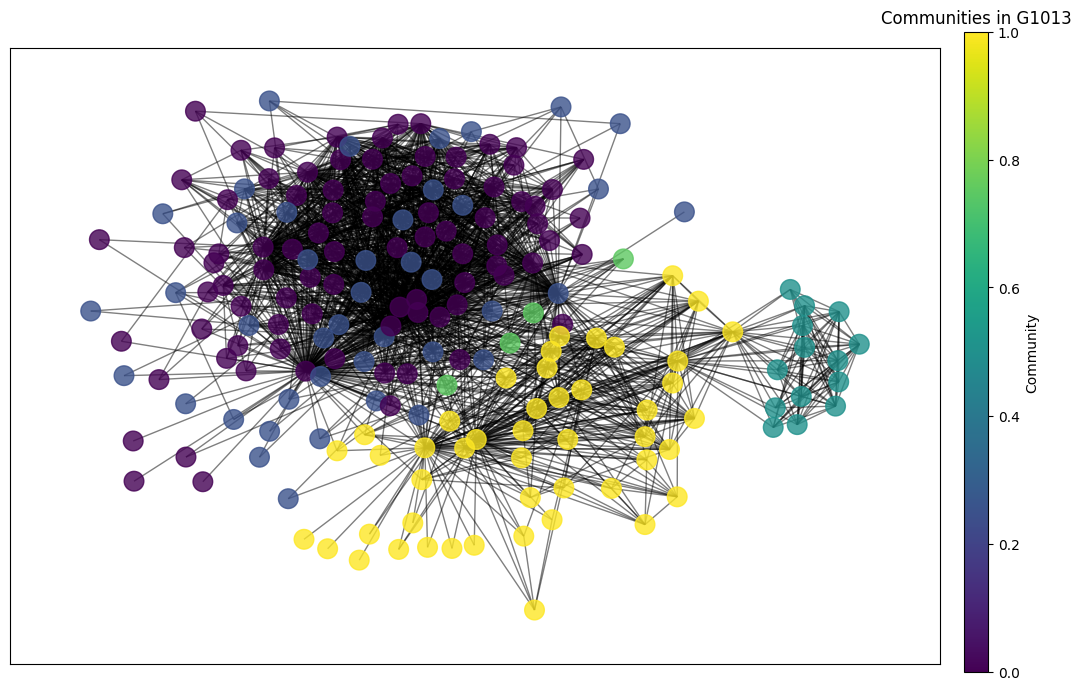

In [98]:
# Visualize the communities on the network
pos = nx.kamada_kawai_layout(G1013_filtered)  # You can use a different layout if needed
node_colors = [partition[node] for node in G1013_filtered.nodes]

plt.figure(figsize=(12, 8))

# Draw network nodes and edges
nx.draw_networkx_nodes(G1013_filtered, pos, node_size=200, node_color=node_colors, cmap=plt.cm.get_cmap('viridis'), alpha=0.8)
nx.draw_networkx_edges(G1013_filtered, pos, alpha=0.5)

# Add colorbar in a separate subplot
cax = plt.axes([0.92, 0.1, 0.02, 0.8])  # [x, y, width, height]
sm = ScalarMappable(cmap=plt.cm.get_cmap('viridis'))
sm.set_array([])
plt.colorbar(sm, label='Community', cax=cax)

plt.title("Communities in G1013")
plt.show()